<a href="https://colab.research.google.com/github/lukassanting/Idiom-Translation/blob/main/End_To_End_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training T5 - Prefix+Idiom



#0. Installs, Imports, Setup


##0.1 Import Libraries & Packages

In [1]:
!pip install sentencepiece -q
!pip install transformers -q
!pip install torch -q
!pip install rich[jupyter] -q

In [2]:
# Drive
from google.colab import drive

# Plots
import IPython
import IPython.display
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Util
import os
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_rows', None)

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

# rich: for a better display on terminal
from rich.table import Column, Table
from rich.text import Text
from rich import box
from rich.console import Console

# define a rich console logger
console = Console(record=True)

# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

<Figure size 864x432 with 0 Axes>

##0.2. Import Data

Either upload the data to the shared Google Drive and use this to download, or upload it directly yourself (whatever is easier)

In [3]:
!git clone https://github.com/marziehf/IdiomTranslationDS data

fatal: destination path 'data' already exists and is not an empty directory.


##0.3 Setup functions & classes

###0.3.1 FUNC: display_df

In [4]:
# to display dataframe in ASCII format
def display_df(df):
    """display dataframe in ASCII format"""

    console = Console()
    table = Table(
        Column("source_text", justify="center"),
        Column("target_text", justify="center"),
        title="Sample Data",
        pad_edge=False,
        box=box.ASCII,
    )

    for i, row in enumerate(df.values.tolist()):
        table.add_row(row[0], row[1])

    console.print(table)

###0.3.2 CLASS: DataSet

A Dataset class for reading and loading the dataset into the dataloader, and then feed it into the neural network for fine-tuning the model.

In [5]:
class DataSet(Dataset):
    """
    Creating a dataset class for reading the dataset and
    loading it into the dataloader, to pass it to the
    neural network for finetuning the model

    """

    def __init__(
        self, dataframe, tokenizer, source_len, target_len, source_text, target_text
    ):
        """
        Initializes a Dataset class

        Args:
            dataframe (pandas.DataFrame): Input dataframe
            tokenizer (transformers.tokenizer): Transformers tokenizer
            source_len (int): Max length of source text
            target_len (int): Max length of target text
            source_text (str): column name of source text
            target_text (str): column name of target text
        """
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = target_len
        self.target_text = self.data[target_text]
        self.source_text = self.data[source_text]

    def __len__(self):
        """returns the length of dataframe"""

        return len(self.target_text)

    def __getitem__(self, index):
        """return the input ids, attention masks and target ids"""

        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])

        # cleaning data so as to ensure data is in string type
        source_text = " ".join(source_text.split())
        target_text = " ".join(target_text.split())

        source = self.tokenizer.batch_encode_plus(
            [source_text],
            max_length=self.source_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        target = self.tokenizer.batch_encode_plus(
            [target_text],
            max_length=self.summ_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        source_ids = source["input_ids"].squeeze()
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze()
        target_mask = target["attention_mask"].squeeze()

        return {
            "source_ids": source_ids.to(dtype=torch.long),
            "source_mask": source_mask.to(dtype=torch.long),
            "target_ids": target_ids.to(dtype=torch.long),
            "target_ids_y": target_ids.to(dtype=torch.long),
        }

###0.3.3 FUNC: train

Train function, which will the put model on training mode, generate outputs and calculate loss

In [6]:
def train(epoch, tokenizer, model, device, loader, optimizer, train_batch_size):

    """
    Function to be called for training with the parameters passed from main function

    Takes 6 arguments as input:
    
        epoch: epoch
        tokenizer: T5 tokenizer
        model: T5 model
        loader: Train Dataloader
        optimizer: Optimizer
        train_batch_size: batch size for the training data


    """

    model.train()
    train_loss = 0
    train_batches = 0
    for _, data in enumerate(loader, 0):
        y = data["target_ids"].to(device, dtype=torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data["source_ids"].to(device, dtype=torch.long)
        mask = data["source_mask"].to(device, dtype=torch.long)

        outputs = model(
            input_ids=ids,
            attention_mask=mask,
            decoder_input_ids=y_ids,
            labels=lm_labels,
        )
        loss = outputs[0]
        train_loss += loss.item()
        train_batches += 1

        # Print training loss every 100 batches
        if _ % 100 == 0:
            #training_logger.add_row(str(epoch), str(_), str(loss.item()))
            console.print("Epoch: ", str(epoch), "Batch: ", str(_), "Loss: ", str(loss.item()))

        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()

    # Print average training loss over the epoch
    train_loss = train_loss/train_batches
    training_logger.add_row(str(epoch), str(train_loss))


###0.3.4 FUNC: validate

Validate function is same as the Train function, but for the validation data



In [7]:
def validate(epoch, tokenizer, model, device, loader, generate_outputs=True):

  """
  Function to evaluate model for predictions

  """
  model.eval()
  predictions = []
  actuals = []
  val_loss = 0
  batches = 0
  with torch.no_grad():
      for _, data in enumerate(loader, 0):
          y = data['target_ids'].to(device, dtype = torch.long)
          ids = data['source_ids'].to(device, dtype = torch.long)
          mask = data['source_mask'].to(device, dtype = torch.long)

          # Find validation loss
          y_ids = y[:, :-1].contiguous()
          lm_labels = y[:, 1:].clone().detach()
          lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100

          outputs = model(
              input_ids=ids,
              attention_mask=mask,
              decoder_input_ids=y_ids,
              labels=lm_labels
              )
          loss = outputs[0]
          val_loss += loss.item()
          batches += 1

          # Generate outputs
          if generate_outputs:
            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask, 
                max_length=150, 
                num_beams=2,
                repetition_penalty=2.5, 
                length_penalty=1.0, 
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]

            predictions.extend(preds)
            actuals.extend(target)

  # Save average loss over epoch
  val_loss = val_loss/batches
  if not generate_outputs:
    validation_logger.add_row(str(epoch), str(val_loss))

  return predictions, actuals

###0.3.5 FUNC: T5Trainer

T5Trainer is our main function. It accepts input data, model type, model paramters to fine-tune the model. Under the hood, it utilizes, our Dataset class for data handling, train function to fine tune the model, validate to evaluate the model.

In [8]:
def T5Trainer(
    train_data, val_data, source_text, target_text, model_params, output_dir="./outputs/"
):

    """
    T5 trainer has 6 arguments:

      train_data: Input dataframe of training data
      val_data: Input dataframe of validation data
      source_text: Column name of the input text i.e. idiomatic sentence
      target_text: Column name of the target text i.e. literal sentence
      model_params: T5 model parameters
      output_dir: Output directory to save fine tuned T5 model.

    """

    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(model_params["SEED"])  # pytorch random seed
    np.random.seed(model_params["SEED"])  # numpy random seed
    torch.backends.cudnn.deterministic = True

    # logging
    console.log(f"""[Model]: Loading {model_params["MODEL"]}...\n""")

    # tokenizer for encoding the text
    tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])

    # Defining the model. The model is then sent to device (GPU/TPU)
    model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL"])
    model = model.to(device)

    # logging
    console.log(f"[Data]: Reading data...\n")

    # Importing the raw dataset
    train_data = train_data[[source_text, target_text]]
    train_data = train_data.reset_index(drop=True)
    val_data = val_data[[source_text, target_text]]
    val_data = val_data.reset_index(drop=True)

    display_df(train_data.head(2))

    # Creation of Dataset and Dataloader
    console.print(f"TRAIN Dataset: {train_data.shape}")
    console.print(f"VALIDATION Dataset: {val_data.shape}\n")

    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = DataSet(
        train_data,
        tokenizer,
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
    )
    val_set = DataSet(
        val_data,
        tokenizer,
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
    )

    # Defining the parameters for creation of dataloaders
    train_params = {
        "batch_size": model_params["TRAIN_BATCH_SIZE"],
        "shuffle": True,
        "num_workers": 0,
    }

    val_params = {
        "batch_size": model_params["VALID_BATCH_SIZE"],
        "shuffle": False,
        "num_workers": 0,
    }

    # Creation of Dataloaders for training and validation.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)

    # Defining the optimizer that will be used to tune the weights of the network in the training session.
    optimizer = torch.optim.Adam(
        params=model.parameters(), lr=model_params["LEARNING_RATE"]
    )

    # Training loop
    console.log(f"[Initiating Fine Tuning]...\n")

    train_batch_size = model_params["TRAIN_BATCH_SIZE"]
    for epoch in range(model_params["TRAIN_EPOCHS"]):
        train(epoch, tokenizer, model, device, training_loader, optimizer, train_batch_size)
        validate(epoch, tokenizer, model, device, val_loader, generate_outputs=False)

    console.print("\n")
    console.print(training_logger)
    console.print("\n")
    console.print(validation_logger)

    console.log(f"[Saving Model]...\n")
    # Saving the model after training
    path = os.path.join(output_dir, "model_files")
    model.save_pretrained(path)
    tokenizer.save_pretrained(path)

    # generating output for validation dataset
    console.log(f"[Generating Validation Outputs]...\n")
    predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
    final_df = pd.DataFrame({"Input": val_data[source_text], "Generated Text": predictions, "Actual Text": actuals})
    final_df.to_csv(os.path.join(output_dir, "predictions.csv"))

    console.save_text(os.path.join(output_dir, "logs.txt"))

    console.log(f"[Validation Outputs Generated.]\n")
    console.print(
        f"""[Model] Model saved @ {os.path.join(output_dir, "model_files")}\n"""
    )
    console.print(
        f"""[Validation] Generation on Validation data saved @ {os.path.join(output_dir,'predictions.csv')}\n"""
    )
    console.print(f"""[Logs] Logs saved @ {os.path.join(output_dir,'logs.txt')}\n""")

# 1. Processing Data

In [9]:
def clean_dataset(data):
  data_clean = data.copy(deep=True)
  for i in range(len(data_clean.columns)):
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&apos;', '\'', x))
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&quot;', '\"', x))
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&#124;', '|', x))
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&#93;', ']', x))
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&#91;', '[', x))
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&gt;', '>', x))
    data_clean.iloc[:,i] = data_clean.iloc[:,i].apply(lambda x: re.sub('&lt;', '<', x))

  return data_clean

In [25]:
base_path="data/en-de/"
en = pd.read_csv(base_path+'idiom_trainplus.en',sep='\n', header=None,names=['en'])
de = pd.read_csv(base_path+'idiom_trainplus.de',sep='\n', header=None,names=['de'])
info = pd.read_csv(base_path+'idiom_trainplus.info',sep='\t',header=None,names=["spread", "en_idiom", "de_idiom",'frequency'])
train_data = pd.concat([en,de,info],axis=1)
train_data.columns = ['input','target',"spread", "en_idiom", "de_idiom",'frequency']
train_data = train_data.drop(['spread','frequency',"en_idiom", "de_idiom"],axis=1)

en = pd.read_csv(base_path+'idiom_test.en',sep='\n', header=None,names=['en'])
de = pd.read_csv(base_path+'idiom_test.de',sep='\n', header=None,names=['de'])
test_data = pd.concat([en,de],axis=1)
test_data.columns = ['input','target']

train_data = clean_dataset(train_data)
test_data = clean_dataset(test_data)

train_data['input'] = 'translate to german: '+ train_data['input']
test_data['input'] = 'translate to german: '+ test_data['input']

from sklearn.model_selection import train_test_split

train_data,val_data=train_test_split(train_data, test_size=0.15, random_state=42)

Index(['en', 'de', 'spread', 'en_idiom', 'de_idiom', 'frequency'], dtype='object')


ValueError: ignored

In [11]:
train_data.head()

,input,target
1080,translate to german: EU integration is like a ...,Die Integration in die EU ist wie Tangotanzen ...
203,translate to german: Whenever we go to a West ...,"Jedes Mal , wenn wir in westafrikanische Lände..."
174,translate to german: I hope that the Irish pre...,"Ich möchte , daß die irische Präsidentschaft i..."
772,translate to german: In a nutshell it would in...,Kurz gesagt würde es die Belastung für den bri...
120,"translate to german: Very well located , easy ...",Die Mitarbeiter waren freundlich und das Hotel...


In [12]:
test_data.head()

,input,target
0,"translate to german: In this day and age , whe...","In einer Zeit wie dieser , in der viele offens..."
1,"translate to german: In Romania , the election...",In Rumänien wird der Wahlkampf die Chance biet...
2,translate to german: Let us work to close the ...,Gemeinsam sollten wir wirksam die Schlupflöche...
3,translate to german: The region is easily reac...,"Das Gebiet ist mit der Eisenbahn erreichbar , ..."
4,translate to german: I cannot enter into debat...,"Ich kann mich auf keine Diskussion einlassen ,..."


In [13]:
# Check max length
lengths_train_in = train_data["input"].str.split(" ")
lengths_test_in = test_data["input"].str.split(" ")
lengths_val_in = val_data["input"].str.split(" ")

print("Max number of tokens input = ", max(lengths_train_in.str.len().max(),lengths_test_in.str.len().max()))

lengths_train_tar = train_data["target"].str.split(" ")
lengths_test_tar = test_data["target"].str.split(" ")
lengths_val_tar = val_data["target"].str.split(" ")

print("Max number of tokens target = ", max(lengths_train_tar.str.len().max(),lengths_test_tar.str.len().max()))

Max number of tokens input =  168
Max number of tokens target =  144


#2. Training Model

In [14]:
# let's define model parameters specific to T5
model_params = {
    "MODEL": "t5-small",  # model_type: t5-base/t5-small/t5-large
    "TRAIN_BATCH_SIZE": 4,  # training batch size
    "VALID_BATCH_SIZE": 4,  # validation batch size
    "TRAIN_EPOCHS": 50,  # number of training epochs
    "VAL_EPOCHS": 1,  # number of validation epochs
    "LEARNING_RATE": 1e-4,  # learning rate
    "MAX_SOURCE_TEXT_LENGTH": 170,  # max length of source text
    "MAX_TARGET_TEXT_LENGTH": 150,  # max length of target text
    "SEED": 42,  # set seed for reproducibility
}


In [15]:
# Initialize training and validation loggers to keep track of model loss

# training logger to log training loss over the epochs and batches
training_logger = Table(
    Column("Epoch", justify="center"),
    # Column("Batch", justify="center"),
    Column("Loss", justify="center"),
    title="Training Loss",
    pad_edge=False,
    box=box.ASCII,
)

# validation logger to log validation loss over the epochs
validation_logger = Table(
    Column("Epoch", justify="center"),
    Column("Loss", justify="center"),
    title="Validation Loss",
    pad_edge=False,
    box=box.ASCII,
)


In [16]:
%mkdir outputs

mkdir: cannot create directory ‘outputs’: File exists


In [17]:
# Train model
T5Trainer(train_data=train_data, val_data= val_data, source_text="input", target_text="target", model_params=model_params, output_dir="outputs")

[19:57:36] [Model]: Loading t5-small...                     <ipython-input-8-31ece74cb2e6>:23
                                                                                             

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:169: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


[19:57:52] [Data]: Reading data...                          <ipython-input-8-31ece74cb2e6>:33
                                                                                             

                                         Sample Data                                         
+-------------------------------------------------------------------------------------------+
|                source_text                  |                 target_text                 |
|---------------------------------------------+---------------------------------------------|
|translate to german: EU integration is like  |      Die Integration in die EU ist wie      |
|  a tango . It takes two for it to work .    |  Tangotanzen : Man braucht dazu immer zwei  |
|                                             |                  Partner .                  |
|  translate to german: Whenever we go to a   |   Jedes Mal , wenn wir in westafrikanische  |
|West African country , we can see the extent | Länder kommen , stellen wir fest , wie groß |
| to which French influence is still present  |  der französische Einfluss dort noch ist .  |
|                  there .                    |                                             |
+-------------------------------------------------------------------------------------------+

TRAIN Dataset: (1956, 2)

VALIDATION Dataset: (346, 2)

           [Initiating Fine Tuning]...                      <ipython-input-8-31ece74cb2e6>:88
                                                                                             

Epoch:  0 Batch:  0 Loss:  4.236312389373779

Epoch:  0 Batch:  100 Loss:  2.4640588760375977

Epoch:  0 Batch:  200 Loss:  2.0432190895080566

Epoch:  0 Batch:  300 Loss:  2.2724668979644775

Epoch:  0 Batch:  400 Loss:  2.402596950531006

Epoch:  1 Batch:  0 Loss:  1.926169753074646

Epoch:  1 Batch:  100 Loss:  0.9635215997695923

Epoch:  1 Batch:  200 Loss:  1.2576704025268555

Epoch:  1 Batch:  300 Loss:  1.4867318868637085

Epoch:  1 Batch:  400 Loss:  1.6007194519042969

Epoch:  2 Batch:  0 Loss:  1.3581115007400513

Epoch:  2 Batch:  100 Loss:  2.1811351776123047

Epoch:  2 Batch:  200 Loss:  1.9880050420761108

Epoch:  2 Batch:  300 Loss:  3.2559614181518555

Epoch:  2 Batch:  400 Loss:  2.2425293922424316

Epoch:  3 Batch:  0 Loss:  1.4615983963012695

Epoch:  3 Batch:  100 Loss:  0.9688267707824707

Epoch:  3 Batch:  200 Loss:  1.7446638345718384

Epoch:  3 Batch:  300 Loss:  1.237941026687622

Epoch:  3 Batch:  400 Loss:  2.4270541667938232

Epoch:  4 Batch:  0 Loss:  2.251739501953125

Epoch:  4 Batch:  100 Loss:  1.2382004261016846

Epoch:  4 Batch:  200 Loss:  0.8187061548233032

Epoch:  4 Batch:  300 Loss:  1.9669184684753418

Epoch:  4 Batch:  400 Loss:  0.9746165871620178

Epoch:  5 Batch:  0 Loss:  0.8698853850364685

Epoch:  5 Batch:  100 Loss:  1.1173319816589355

Epoch:  5 Batch:  200 Loss:  1.7615560293197632

Epoch:  5 Batch:  300 Loss:  1.828518271446228

Epoch:  5 Batch:  400 Loss:  1.1084927320480347

Epoch:  6 Batch:  0 Loss:  1.571602702140808

Epoch:  6 Batch:  100 Loss:  1.310165524482727

Epoch:  6 Batch:  200 Loss:  0.7214107513427734

Epoch:  6 Batch:  300 Loss:  3.057178258895874

Epoch:  6 Batch:  400 Loss:  1.5342189073562622

Epoch:  7 Batch:  0 Loss:  0.7915360927581787

Epoch:  7 Batch:  100 Loss:  1.53759765625

Epoch:  7 Batch:  200 Loss:  1.0175974369049072

Epoch:  7 Batch:  300 Loss:  0.9033318161964417

Epoch:  7 Batch:  400 Loss:  0.9631489515304565

Epoch:  8 Batch:  0 Loss:  0.9023591876029968

Epoch:  8 Batch:  100 Loss:  0.9947782754898071

Epoch:  8 Batch:  200 Loss:  1.1143466234207153

Epoch:  8 Batch:  300 Loss:  0.9125391840934753

Epoch:  8 Batch:  400 Loss:  0.9453852772712708

Epoch:  9 Batch:  0 Loss:  1.238229751586914

Epoch:  9 Batch:  100 Loss:  0.7821601629257202

Epoch:  9 Batch:  200 Loss:  0.962096095085144

Epoch:  9 Batch:  300 Loss:  1.5217210054397583

Epoch:  9 Batch:  400 Loss:  1.7364798784255981

Epoch:  10 Batch:  0 Loss:  1.288854718208313

Epoch:  10 Batch:  100 Loss:  0.5391069650650024

Epoch:  10 Batch:  200 Loss:  0.7265322208404541

Epoch:  10 Batch:  300 Loss:  0.6418563723564148

Epoch:  10 Batch:  400 Loss:  1.042300820350647

Epoch:  11 Batch:  0 Loss:  0.8335849046707153

Epoch:  11 Batch:  100 Loss:  1.4041998386383057

Epoch:  11 Batch:  200 Loss:  0.8887423276901245

Epoch:  11 Batch:  300 Loss:  0.9926320314407349

Epoch:  11 Batch:  400 Loss:  0.7929717302322388

Epoch:  12 Batch:  0 Loss:  0.9599723219871521

Epoch:  12 Batch:  100 Loss:  0.9841362237930298

Epoch:  12 Batch:  200 Loss:  0.8428197503089905

Epoch:  12 Batch:  300 Loss:  0.964732825756073

Epoch:  12 Batch:  400 Loss:  0.853690505027771

Epoch:  13 Batch:  0 Loss:  1.074328064918518

Epoch:  13 Batch:  100 Loss:  0.8108710050582886

Epoch:  13 Batch:  200 Loss:  1.5822783708572388

Epoch:  13 Batch:  300 Loss:  1.1755584478378296

Epoch:  13 Batch:  400 Loss:  1.1093568801879883

Epoch:  14 Batch:  0 Loss:  1.0039087533950806

Epoch:  14 Batch:  100 Loss:  1.4174507856369019

Epoch:  14 Batch:  200 Loss:  0.8437080979347229

Epoch:  14 Batch:  300 Loss:  1.2761884927749634

Epoch:  14 Batch:  400 Loss:  1.5186179876327515

Epoch:  15 Batch:  0 Loss:  1.3339321613311768

Epoch:  15 Batch:  100 Loss:  1.851038932800293

Epoch:  15 Batch:  200 Loss:  0.7788434624671936

Epoch:  15 Batch:  300 Loss:  1.2878772020339966

Epoch:  15 Batch:  400 Loss:  1.080927848815918

Epoch:  16 Batch:  0 Loss:  0.6806558966636658

Epoch:  16 Batch:  100 Loss:  1.0712511539459229

Epoch:  16 Batch:  200 Loss:  0.5685485005378723

Epoch:  16 Batch:  300 Loss:  0.8718826770782471

Epoch:  16 Batch:  400 Loss:  1.0831869840621948

Epoch:  17 Batch:  0 Loss:  0.535735547542572

Epoch:  17 Batch:  100 Loss:  1.0253746509552002

Epoch:  17 Batch:  200 Loss:  0.9251050353050232

Epoch:  17 Batch:  300 Loss:  1.337530255317688

Epoch:  17 Batch:  400 Loss:  0.5605518817901611

Epoch:  18 Batch:  0 Loss:  0.8876765966415405

Epoch:  18 Batch:  100 Loss:  1.8546819686889648

Epoch:  18 Batch:  200 Loss:  0.6181114315986633

Epoch:  18 Batch:  300 Loss:  0.98160320520401

Epoch:  18 Batch:  400 Loss:  0.3993627429008484

Epoch:  19 Batch:  0 Loss:  0.5272835493087769

Epoch:  19 Batch:  100 Loss:  1.4909542798995972

Epoch:  19 Batch:  200 Loss:  0.776563823223114

Epoch:  19 Batch:  300 Loss:  0.7964534759521484

Epoch:  19 Batch:  400 Loss:  0.7224251627922058

Epoch:  20 Batch:  0 Loss:  0.803223729133606

Epoch:  20 Batch:  100 Loss:  1.2775211334228516

Epoch:  20 Batch:  200 Loss:  1.7925972938537598

Epoch:  20 Batch:  300 Loss:  0.7251591682434082

Epoch:  20 Batch:  400 Loss:  1.0882471799850464

Epoch:  21 Batch:  0 Loss:  0.5881310701370239

Epoch:  21 Batch:  100 Loss:  0.3491443693637848

Epoch:  21 Batch:  200 Loss:  0.6569535136222839

Epoch:  21 Batch:  300 Loss:  1.1625250577926636

Epoch:  21 Batch:  400 Loss:  0.7643752098083496

Epoch:  22 Batch:  0 Loss:  0.4380040764808655

Epoch:  22 Batch:  100 Loss:  0.9795911312103271

Epoch:  22 Batch:  200 Loss:  1.2729755640029907

Epoch:  22 Batch:  300 Loss:  0.4979802370071411

Epoch:  22 Batch:  400 Loss:  0.5317868590354919

Epoch:  23 Batch:  0 Loss:  1.4795621633529663

Epoch:  23 Batch:  100 Loss:  0.7865933179855347

Epoch:  23 Batch:  200 Loss:  0.5317710638046265

Epoch:  23 Batch:  300 Loss:  0.5290281772613525

Epoch:  23 Batch:  400 Loss:  1.360757827758789

Epoch:  24 Batch:  0 Loss:  0.6873344779014587

Epoch:  24 Batch:  100 Loss:  1.5193636417388916

Epoch:  24 Batch:  200 Loss:  0.527279794216156

Epoch:  24 Batch:  300 Loss:  0.7028399705886841

Epoch:  24 Batch:  400 Loss:  0.5806851983070374

Epoch:  25 Batch:  0 Loss:  0.6825536489486694

Epoch:  25 Batch:  100 Loss:  1.2871299982070923

Epoch:  25 Batch:  200 Loss:  0.7043249607086182

Epoch:  25 Batch:  300 Loss:  0.935539960861206

Epoch:  25 Batch:  400 Loss:  0.45678573846817017

Epoch:  26 Batch:  0 Loss:  0.4463227689266205

Epoch:  26 Batch:  100 Loss:  0.4817022979259491

Epoch:  26 Batch:  200 Loss:  0.7362359166145325

Epoch:  26 Batch:  300 Loss:  0.3219186067581177

Epoch:  26 Batch:  400 Loss:  0.5657811164855957

Epoch:  27 Batch:  0 Loss:  0.7112216949462891

Epoch:  27 Batch:  100 Loss:  0.5484179854393005

Epoch:  27 Batch:  200 Loss:  0.7195936441421509

Epoch:  27 Batch:  300 Loss:  0.3356325924396515

Epoch:  27 Batch:  400 Loss:  0.6361315250396729

Epoch:  28 Batch:  0 Loss:  0.572532057762146

Epoch:  28 Batch:  100 Loss:  0.8573509454727173

Epoch:  28 Batch:  200 Loss:  0.4238813519477844

Epoch:  28 Batch:  300 Loss:  0.36386191844940186

Epoch:  28 Batch:  400 Loss:  0.5979854464530945

Epoch:  29 Batch:  0 Loss:  1.4362449645996094

Epoch:  29 Batch:  100 Loss:  0.863102376461029

Epoch:  29 Batch:  200 Loss:  0.5086944103240967

Epoch:  29 Batch:  300 Loss:  0.41551485657691956

Epoch:  29 Batch:  400 Loss:  1.4380457401275635

Epoch:  30 Batch:  0 Loss:  0.6368900537490845

Epoch:  30 Batch:  100 Loss:  0.5291280150413513

Epoch:  30 Batch:  200 Loss:  0.6138681173324585

Epoch:  30 Batch:  300 Loss:  0.901388943195343

Epoch:  30 Batch:  400 Loss:  1.283475637435913

Epoch:  31 Batch:  0 Loss:  0.37464189529418945

Epoch:  31 Batch:  100 Loss:  0.460188627243042

Epoch:  31 Batch:  200 Loss:  0.8040042519569397

Epoch:  31 Batch:  300 Loss:  0.34427106380462646

Epoch:  31 Batch:  400 Loss:  0.47020888328552246

Epoch:  32 Batch:  0 Loss:  1.3739362955093384

Epoch:  32 Batch:  100 Loss:  1.0814958810806274

Epoch:  32 Batch:  200 Loss:  0.39271336793899536

Epoch:  32 Batch:  300 Loss:  0.38334205746650696

Epoch:  32 Batch:  400 Loss:  0.41012391448020935

Epoch:  33 Batch:  0 Loss:  0.3041055202484131

Epoch:  33 Batch:  100 Loss:  1.1023422479629517

Epoch:  33 Batch:  200 Loss:  0.6754214763641357

Epoch:  33 Batch:  300 Loss:  0.96293044090271

Epoch:  33 Batch:  400 Loss:  0.30006855726242065

Epoch:  34 Batch:  0 Loss:  0.4698439836502075

Epoch:  34 Batch:  100 Loss:  0.5879216194152832

Epoch:  34 Batch:  200 Loss:  0.22473420202732086

Epoch:  34 Batch:  300 Loss:  0.8432608246803284

Epoch:  34 Batch:  400 Loss:  0.39282822608947754

Epoch:  35 Batch:  0 Loss:  0.6147429347038269

Epoch:  35 Batch:  100 Loss:  0.544684886932373

Epoch:  35 Batch:  200 Loss:  0.8782222270965576

Epoch:  35 Batch:  300 Loss:  0.33798569440841675

Epoch:  35 Batch:  400 Loss:  0.6262770891189575

Epoch:  36 Batch:  0 Loss:  0.19239123165607452

Epoch:  36 Batch:  100 Loss:  0.24053576588630676

Epoch:  36 Batch:  200 Loss:  0.40002766251564026

Epoch:  36 Batch:  300 Loss:  0.47755149006843567

Epoch:  36 Batch:  400 Loss:  0.43475741147994995

Epoch:  37 Batch:  0 Loss:  0.36948010325431824

Epoch:  37 Batch:  100 Loss:  0.5254663228988647

Epoch:  37 Batch:  200 Loss:  0.36269327998161316

Epoch:  37 Batch:  300 Loss:  0.3114320933818817

Epoch:  37 Batch:  400 Loss:  0.29507336020469666

Epoch:  38 Batch:  0 Loss:  0.5635018348693848

Epoch:  38 Batch:  100 Loss:  1.4174915552139282

Epoch:  38 Batch:  200 Loss:  0.40237438678741455

Epoch:  38 Batch:  300 Loss:  0.5759990811347961

Epoch:  38 Batch:  400 Loss:  0.46870842576026917

Epoch:  39 Batch:  0 Loss:  0.47306492924690247

Epoch:  39 Batch:  100 Loss:  0.5875833630561829

Epoch:  39 Batch:  200 Loss:  0.29394176602363586

Epoch:  39 Batch:  300 Loss:  0.23644569516181946

Epoch:  39 Batch:  400 Loss:  0.3645611107349396

Epoch:  40 Batch:  0 Loss:  0.33803778886795044

Epoch:  40 Batch:  100 Loss:  0.2960195541381836

Epoch:  40 Batch:  200 Loss:  0.18048277497291565

Epoch:  40 Batch:  300 Loss:  0.4315151572227478

Epoch:  40 Batch:  400 Loss:  0.21168504655361176

Epoch:  41 Batch:  0 Loss:  0.2810181677341461

Epoch:  41 Batch:  100 Loss:  0.36823660135269165

Epoch:  41 Batch:  200 Loss:  0.4031352996826172

Epoch:  41 Batch:  300 Loss:  0.5110989212989807

Epoch:  41 Batch:  400 Loss:  0.22333663702011108

Epoch:  42 Batch:  0 Loss:  0.340351402759552

Epoch:  42 Batch:  100 Loss:  0.31829336285591125

Epoch:  42 Batch:  200 Loss:  0.5083778500556946

Epoch:  42 Batch:  300 Loss:  0.5283734798431396

Epoch:  42 Batch:  400 Loss:  0.35265952348709106

Epoch:  43 Batch:  0 Loss:  0.26693060994148254

Epoch:  43 Batch:  100 Loss:  0.16852009296417236

Epoch:  43 Batch:  200 Loss:  0.4196045398712158

Epoch:  43 Batch:  300 Loss:  0.22926431894302368

Epoch:  43 Batch:  400 Loss:  0.752090334892273

Epoch:  44 Batch:  0 Loss:  0.23250196874141693

Epoch:  44 Batch:  100 Loss:  0.37617209553718567

Epoch:  44 Batch:  200 Loss:  0.3133851885795593

Epoch:  44 Batch:  300 Loss:  0.484210342168808

Epoch:  44 Batch:  400 Loss:  0.5004000067710876

Epoch:  45 Batch:  0 Loss:  0.2950890362262726

Epoch:  45 Batch:  100 Loss:  0.2650582492351532

Epoch:  45 Batch:  200 Loss:  0.32950085401535034

Epoch:  45 Batch:  300 Loss:  0.14927390217781067

Epoch:  45 Batch:  400 Loss:  0.18873687088489532

Epoch:  46 Batch:  0 Loss:  0.29664596915245056

Epoch:  46 Batch:  100 Loss:  0.18432392179965973

Epoch:  46 Batch:  200 Loss:  0.38885214924812317

Epoch:  46 Batch:  300 Loss:  0.5065903663635254

Epoch:  46 Batch:  400 Loss:  0.4219374358654022

Epoch:  47 Batch:  0 Loss:  0.29134878516197205

Epoch:  47 Batch:  100 Loss:  0.3995649814605713

Epoch:  47 Batch:  200 Loss:  0.2664080560207367

Epoch:  47 Batch:  300 Loss:  0.32608601450920105

Epoch:  47 Batch:  400 Loss:  0.46450093388557434

Epoch:  48 Batch:  0 Loss:  0.24669206142425537

Epoch:  48 Batch:  100 Loss:  0.29027417302131653

Epoch:  48 Batch:  200 Loss:  0.5875284671783447

Epoch:  48 Batch:  300 Loss:  0.1558266580104828

Epoch:  48 Batch:  400 Loss:  0.29548436403274536

Epoch:  49 Batch:  0 Loss:  0.37228113412857056

Epoch:  49 Batch:  100 Loss:  0.23594613373279572

Epoch:  49 Batch:  200 Loss:  0.3090393543243408

Epoch:  49 Batch:  300 Loss:  0.24135424196720123

Epoch:  49 Batch:  400 Loss:  0.34724339842796326

        Training Loss        
+---------------------------+
|Epoch |        Loss        |
|------+--------------------|
|  0   | 2.0382370199162536 |
|  1   | 1.7738327014665662 |
|  2   | 1.6597901245080133 |
|  3   | 1.5901761887507448 |
|  4   | 1.5219170531612232 |
|  5   | 1.4396018582131478 |
|  6   | 1.3874955388178367 |
|  7   | 1.3306300226286634 |
|  8   | 1.2834014910252305 |
|  9   | 1.2350943385945263 |
| 10   |  1.19037335050618  |
| 11   | 1.1425610546075982 |
| 12   | 1.1103674568281583 |
| 13   |  1.062964110774253 |
| 14   |  1.034954667274206 |
| 15   | 0.9986699969490613 |
| 16   | 0.9634717785751405 |
| 17   | 0.9303211451856637 |
| 18   | 0.9066905254966642 |
| 19   | 0.8687861991440592 |
| 20   | 0.8496016070002914 |
| 21   |  0.819043483531792 |
| 22   | 0.7949097208328286 |
| 23   | 0.7671389526750413 |
| 24   |   0.7441803356804  |
| 25   | 0.7194659736136961 |
| 26   | 0.6877271900208694 |
| 27   |  0.675957706320749 |
| 28   | 0.6447541604317527 |
| 29   |  0.631453555359187 |
| 30   | 0.6134647808984257 |
| 31   | 0.5900739941799323 |
| 32   |  0.568418851964069 |
| 33   | 0.5571592530589894 |
| 34   | 0.5335930694191734 |
| 35   | 0.5230344841694783 |
| 36   |  0.508079255681584 |
| 37   |  0.488293112238492 |
| 38   | 0.46410861637268086|
| 39   |  0.451381468334081 |
| 40   | 0.44082337764143215|
| 41   |  0.422517832650485 |
| 42   |  0.41236558974033  |
| 43   | 0.3991406239980569 |
| 44   | 0.38229125983449336|
| 45   | 0.37528397793479734|
| 46   | 0.3618504978823028 |
| 47   | 0.3561823206567082 |
| 48   | 0.33741915225982666|
| 49   | 0.32210951592537035|
+---------------------------+

      Validation Loss       
+--------------------------+
|Epoch |        Loss       |
|------+-------------------|
|  0   | 1.6725029393859294|
|  1   | 1.6395886694562847|
|  2   | 1.6394798060258229|
|  3   | 1.6258584990583618|
|  4   | 1.6314676023762802|
|  5   | 1.6315494210555637|
|  6   | 1.648242897000806 |
|  7   | 1.6563510898200946|
|  8   | 1.6633949238678505|
|  9   |  1.67822488834118 |
| 10   | 1.700874603342736 |
| 11   | 1.7179748799609043|
| 12   | 1.729856589744831 |
| 13   | 1.7530336078556104|
| 14   | 1.771279377498846 |
| 15   | 1.7876011838858155|
| 16   | 1.793221183891954 |
| 17   | 1.831762520746253 |
| 18   | 1.8470730055337665|
| 19   | 1.8711481224531414|
| 20   | 1.8918711878787513|
| 21   | 1.9054687495889335|
| 22   | 1.9428488721792725|
| 23   | 1.9489463225178334|
| 24   | 1.9788126842728977|
| 25   | 2.004737573108454 |
| 26   | 2.026953257363418 |
| 27   | 2.052147119894795 |
| 28   | 2.077860828788801 |
| 29   | 2.076988457263201 |
| 30   | 2.1165394947446625|
| 31   | 2.132202445090502 |
| 32   | 2.175598202765673 |
| 33   | 2.1776669888660827|
| 34   |  2.21362448971847 |
| 35   |  2.21219658440557 |
| 36   | 2.2428775059765784|
| 37   | 2.289619944561487 |
| 38   | 2.299756251532456 |
| 39   | 2.3267117896299254|
| 40   | 2.343077203323101 |
| 41   | 2.3691515840333084|
| 42   | 2.3886989540067214|
| 43   | 2.4045885287482163|
| 44   | 2.4389599116369225|
| 45   | 2.457963383745873 |
| 46   | 2.4758167198334617|
| 47   | 2.5125306693986915|
| 48   | 2.529544907054682 |
| 49   | 2.5663878013347756|
+--------------------------+

[20:44:01] [Saving Model]...                               <ipython-input-8-31ece74cb2e6>:100
                                                                                             

[20:44:02] [Generating Validation Outputs]...              <ipython-input-8-31ece74cb2e6>:107
                                                                                             

[20:45:31] [Validation Outputs Generated.]                 <ipython-input-8-31ece74cb2e6>:114
                                                                                             

[Model] Model saved @ outputs/model_files

[Validation] Generation on Validation data saved @ outputs/predictions.csv

[Logs] Logs saved @ outputs/logs.txt

In [18]:
# Save the training loss to csv
table_data = {x.header: [Text.from_markup(y).plain for y in x.cells] for x in training_logger.columns}
training_logger_df = pd.DataFrame(table_data)
training_logger_df.to_csv("outputs/"+"train_loss.csv", sep="=")

# Save the validation loss to csv
table_data = {x.header: [Text.from_markup(y).plain for y in x.cells] for x in validation_logger.columns}
validation_logger_df = pd.DataFrame(table_data)
validation_logger_df.to_csv("outputs/"+"val_loss.csv", sep="=")

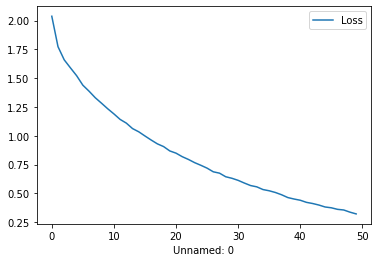

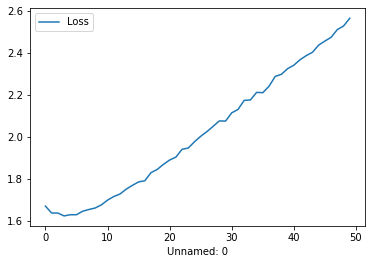

In [19]:
# Plot the loss
train_loss = pd.read_csv("outputs/"+"train_loss.csv", sep="=")
train_loss.plot(0,2)
val_loss = pd.read_csv("outputs/"+"val_loss.csv", sep="=")
val_loss.plot(0,2)

In [20]:
!zip -r outputs.zip outputs

  adding: outputs/ (stored 0%)
  adding: outputs/logs.txt (deflated 70%)
  adding: outputs/val_loss.csv (deflated 48%)
  adding: outputs/train_loss.csv (deflated 48%)
  adding: outputs/model_files/ (stored 0%)
  adding: outputs/model_files/config.json (deflated 63%)
  adding: outputs/model_files/spiece.model (deflated 48%)
  adding: outputs/model_files/tokenizer_config.json (deflated 80%)
  adding: outputs/model_files/pytorch_model.bin (deflated 7%)
  adding: outputs/model_files/special_tokens_map.json (deflated 83%)
  adding: outputs/predictions.csv (deflated 63%)
